In [1]:
from PIL import Image, ImageDraw
import torchvision.transforms as transforms
import numpy as np
import torch
from torch.utils.data import TensorDataset


def generate_img(x_position, y_position, shape, color, img_size, size=20):
    """Generate an RGB image from the provided latent factors
    
    Args:
        x_position (float): normalized x position
        y_position (float): normalized y position
        shape (string): can only be 'circle' or 'square'
        color (string): color name or rgb string
        img_size (int): describing the image size (img_size, img_size)
        size (int): size of shape
        
    Returns:
        torch tensor [3, img_size, img_size] (dtype=torch.float32)
    """
    # creation of image
    img = Image.new('RGB', (img_size, img_size), color='black')
    # map (x, y) position to pixel coordinates
    x_position = (img_size - 2 - size) * x_position 
    y_position = (img_size - 2 - size) * y_position
    # define coordinates
    x_0, y_0 = x_position, y_position
    x_1, y_1 = x_position + size, y_position + size
    # draw shapes
    img1 = ImageDraw.Draw(img)
    if shape == 'square':
        img1.rectangle([(x_0, y_0), (x_1, y_1)], fill=color)
    elif shape == 'circle':       
        img1.ellipse([(x_0, y_0), (x_1, y_1)], fill=color)
    return transforms.ToTensor()(img).type(torch.float32)


def generate_dataset(img_size, shape_sizes, num_pos, shapes, colors):
    """procedurally generated from 4 ground truth independent latent factors, 
       these factors are/can be 
           Position X: num_pos values in [0, 1]
           Poistion Y: num_pos values in [0, 1]
           Shape: square, circle
           Color: standard HTML color name or 'rgb(x, y, z)'
    
    Args:
           img_size (int): describing the image size (img_size, img_size)  
           shape_sizes (list): sizes of shapes
           num_pos (int): discretized positions
           shapes (list): shapes (can only be 'circle', 'square')
           colors (list): colors
    
    Returns:
           data: torch tensor [n_samples, 3, img_size, img_size]
           latents: each entry describes the latents of corresp. data entry
    """
    num_shapes, num_colors, sizes = len(shapes), len(colors), len(shape_sizes)
    
    n_samples = num_pos*num_pos*num_shapes*num_colors*sizes
    data = torch.empty([n_samples, 3, img_size, img_size])
    latents = np.empty([n_samples], dtype=object)
    
    index = 0
    for x_pos in np.linspace(0, 1, num_pos):
        for y_pos in np.linspace(0, 1, num_pos):
            for shape in shapes:
                for size in shape_sizes:
                    for color in colors:
                        img = generate_img(x_pos, y_pos, shape, color, 
                                           img_size, size)
                        data[index] = img
                        latents[index] = [x_pos, y_pos, shape, color]
                    
                        index += 1
    return data, latents


circles_data, latents = generate_dataset(img_size=64, shape_sizes=[16],
                                         num_pos=35,
                                         shapes=['circle'],
                                         colors=['red', 'green', 'blue'])
sprites_dataset = TensorDataset(circles_data)

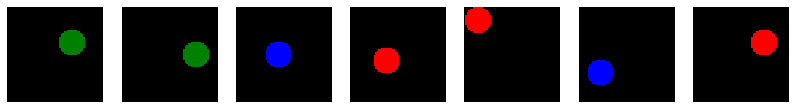

In [2]:
import matplotlib.pyplot as plt

n_samples = 7

fig = plt.figure(figsize=(14, 2))
i_samples = np.random.choice(range(len(sprites_dataset)), 
                             n_samples, replace=False)

for counter, i_sample in enumerate(i_samples):
    img = sprites_dataset[i_sample][0]
  
    plt.subplot(1, n_samples, counter + 1)
    plt.imshow(transforms.ToPILImage()(img))
    plt.axis('off')

In [3]:
from torch import nn


class Encoder(nn.Module):
    """"Encoder class for use in convolutional VAE
      
    Args:
        latent_dim: dimensionality of latent distribution

    Attributes:
        encoder_conv: convolution layers of encoder
        fc_mu: fully connected layer for mean in latent space
        fc_log_var: fully connceted layers for log variance in latent space
    """

    def __init__(self, latent_dim=6):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder_conv = nn.Sequential(
            # shape: [batch_size, 3, 64, 64]
            nn.Conv2d(3,  64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # shape: [batch_size, 64, 32, 32]
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # shape: [batch_size, 64, 4, 4],
            nn.Flatten(),
            # shape: [batch_size, 1024]
            nn.Linear(1024, 256),
            nn.ReLU(),
            # shape: [batch_size, 256]
        )
        self.fc_mu = nn.Sequential(
            nn.Linear(in_features=256, out_features=self.latent_dim),
        )
        self.fc_log_var = nn.Sequential(
            nn.Linear(in_features=256, out_features=self.latent_dim),
        )
        return

    def forward(self, inp):
        out = self.encoder_conv(inp)
        mu = self.fc_mu(out)
        log_var = self.fc_log_var(out)
        return [mu, log_var]


class Decoder(nn.Module):
    """(standard) Decoder class for use in convolutional VAE,
    a Gaussian distribution with fixed variance (identity times fixed variance
    as covariance matrix) used as the decoder distribution
      
    Args:
        latent_dim: dimensionality of latent distribution
        fixed_variance: variance of distribution

    Attributes:
        decoder_upsampling: linear upsampling layer(s)
        decoder_deconv: deconvolution layers of decoder (also upsampling)
    """

    def __init__(self, latent_dim, fixed_variance):
        super().__init__()
        self.latent_dim = latent_dim
        self.coder_type = 'Gaussian with fixed variance'
        self.fixed_variance = fixed_variance

        self.decoder_upsampling = nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            # reshaped into [batch_size, 64, 2, 2]
        )
        self.decoder_deconv = nn.Sequential(
            # shape: [batch_size, 64, 2, 2]
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # shape: [batch_size, 64, 4, 4]
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64,  3, kernel_size=4, stride=2, padding=1),
            # shape: [batch_size, 3, 64, 64]
        )
        return

    def forward(self, inp):
        ups_inp = self.decoder_upsampling(inp)
        ups_inp = ups_inp.view(-1, 64, 2, 2)
        mu = self.decoder_deconv(ups_inp)
        return mu
          
          
class SpatialBroadcastDecoder(nn.Module):
    """SBD class for use in convolutional VAE,
      a Gaussian distribution with fixed variance (identity times fixed 
      variance as covariance matrix) used as the decoder distribution

    Args:
        latent_dim: dimensionality of latent distribution
        fixed_variance: variance of distribution

    Attributes:
        img_size: image size (necessary for tiling)
        decoder_convs: convolution layers of decoder (also upsampling)
    """

    def __init__(self, latent_dim, fixed_variance):
        super().__init__()
        self.img_size = 64
        self.coder_type = 'Gaussian with fixed variance'
        self.latent_dim = latent_dim
        self.fixed_variance = fixed_variance

        x = torch.linspace(-1, 1, self.img_size)
        y = torch.linspace(-1, 1, self.img_size)
        x_grid, y_grid = torch.meshgrid(x, y)
        # reshape into [1, 1, img_size, img_size] and save in state_dict
        self.register_buffer('x_grid', x_grid.view((1, 1) + x_grid.shape))
        self.register_buffer('y_grid', y_grid.view((1, 1) + y_grid.shape))

        self.decoder_convs = nn.Sequential(
            # shape [batch_size, latent_dim + 2, 64, 64]
            nn.Conv2d(in_channels=self.latent_dim+2, out_channels=64,
                      stride=(1, 1), kernel_size=(3,3), padding=1),           
            nn.ReLU(),
            # shape [batch_size, 64, 64, 64]
            nn.Conv2d(in_channels=64, out_channels=64, stride=(1,1), 
                      kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            # shape [batch_size, 64, 64, 64]
            nn.Conv2d(in_channels=64, out_channels=3, stride=(1,1), 
                      kernel_size=(3, 3), padding=1),
            # shape [batch_size, 3, 64, 64]         
        )
        return

    def forward(self, z):
        batch_size = z.shape[0]
        # reshape z into [batch_size, latent_dim, 1, 1]
        z = z.view(z.shape + (1, 1))
        # tile across image [batch_size, latent_im, img_size, img_size]
        z_b = z.expand(-1, -1, self.img_size, self.img_size)
        # upsample x_grid and y_grid to [batch_size, 1, img_size, img_size]
        x_b = self.x_grid.expand(batch_size, -1, -1, -1)
        y_b = self.y_grid.expand(batch_size, -1, -1, -1)
        # concatenate vectors [batch_size, latent_dim+2, img_size, img_size]
        z_sb = torch.cat((z_b, x_b, y_b), dim=1)
        # apply convolutional layers
        mu_D = self.decoder_convs(z_sb)
        return mu_D

In [4]:
from torch.distributions.multivariate_normal import MultivariateNormal


class VAE(nn.Module):
    """A simple VAE class

    Args:
        vae_tpe: type of VAE either 'Standard' or 'SBD'
        latent_dim: dimensionality of latent distribution
        fixed_var: fixed variance of decoder distribution
    """

    def __init__(self, vae_type, latent_dim, fixed_var):
        super().__init__()
        self.vae_type = vae_type

        if self.vae_type == 'Standard':
            self.decoder = Decoder(latent_dim=latent_dim, 
                                  fixed_variance=fixed_var)
        else:
            self.decoder = SpatialBroadcastDecoder(latent_dim=latent_dim,
                                                   fixed_variance=fixed_var)

        self.encoder = Encoder(latent_dim=latent_dim)
        self.normal_dist = MultivariateNormal(torch.zeros(latent_dim), 
                                              torch.eye(latent_dim))
        return

    def forward(self, x):      
        z, mu_E, log_var_E = self.encode(x)
        # regularization term per batch, i.e., size: (batch_size)
        regularization_term = 0.5 * (1 + log_var_E - mu_E**2
                                      - torch.exp(log_var_E)).sum(axis=1)

        batch_size = x.shape[0]
        if self.decoder.coder_type == 'Gaussian with fixed variance':
            # x_rec has shape (batch_size, 3, 64, 64)
            x_rec = self.decode(z)
            # reconstruction accuracy per batch, i.e., size: (batch_size)
            factor = 0.5 * (1/self.decoder.fixed_variance)
            recons_acc = - factor * ((x.view(batch_size, -1) - 
                                    x_rec.view(batch_size, -1))**2
                                  ).sum(axis=1)
        return -regularization_term.mean(), -recons_acc.mean()

    def reconstruct(self, x):
        mu_E, log_var_E = self.encoder(x)
        x_rec = self.decoder(mu_E)
        return x_rec

    def encode(self, x):
        # get encoder distribution parameters
        mu_E, log_var_E = self.encoder(x)
        # sample noise variable for each batch
        batch_size = x.shape[0]
        epsilon = self.normal_dist.sample(sample_shape=(batch_size, )
                                          ).to(x.device)
        # get latent variable by reparametrization trick
        z = mu_E + torch.exp(0.5*log_var_E) * epsilon
        return z, mu_E, log_var_E

    def decode(self, z):
        # get decoder distribution parameters
        mu_D = self.decoder(z)
        return mu_D

In [5]:
from livelossplot import PlotLosses
from torch.utils.data import DataLoader

  
def train(dataset, epochs, VAE):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
    print('Device: {}'.format(device))

    data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

    VAE.to(device)
    optimizer = torch.optim.Adam(VAE.parameters(), lr=3e-4)

    losses_plot = PlotLosses(groups={'avg log loss': 
                                    ['kl loss', 'reconstruction loss']})
    print('Start training with {} decoder\n'.format(VAE.vae_type))
    for epoch in range(1, epochs +1):
        avg_kl = 0 
        avg_recons_err = 0
        for counter, mini_batch_data in enumerate(data_loader):
            VAE.zero_grad()

            kl_div, recons_err = VAE(mini_batch_data[0].to(device))
            loss = kl_div + recons_err
            loss.backward()
            optimizer.step()

            avg_kl += kl_div.item() / len(dataset)
            avg_recons_err += recons_err.item() / len(dataset)

        losses_plot.update({'kl loss': np.log(avg_kl), 
                            'reconstruction loss': np.log(avg_recons_err)})
        losses_plot.send()
    trained_VAE = VAE
    return trained_VAE

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
  

def reconstructions_and_latent_traversals(STD_VAE, SBD_VAE, dataset, SEED=1):
    np.random.seed(SEED)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    latent_dims = STD_VAE.encoder.latent_dim

    n_samples = 7
    i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)

    # preperation for latent traversal
    i_latent = i_samples[n_samples//2]
    lat_image = dataset[i_latent][0]
    sweep = np.linspace(-2, 2, n_samples)

    fig = plt.figure(constrained_layout=False, figsize=(2*n_samples, 2+latent_dims))
    grid = plt.GridSpec(latent_dims + 5, n_samples*2 + 3, 
                        hspace=0.2, wspace=0.02, figure=fig)
    # standard VAE
    for counter, i_sample in enumerate(i_samples):
        orig_image = dataset[i_sample][0]
        # original
        main_ax = fig.add_subplot(grid[1, counter + 1])
        main_ax.imshow(transforms.ToPILImage()(orig_image))
        main_ax.axis('off')
        main_ax.set_aspect('equal')

        # reconstruction
        x_rec = STD_VAE.reconstruct(orig_image.unsqueeze(0).to(device))
        # clamp output into [0, 1] and prepare for plotting
        recons_image =  torch.clamp(x_rec, 0, 1).squeeze(0).cpu()

        main_ax = fig.add_subplot(grid[2, counter + 1])
        main_ax.imshow(transforms.ToPILImage()(recons_image))
        main_ax.axis('off')
        main_ax.set_aspect('equal')
    # latent dimension traversal
    z, mu_E, log_var_E = STD_VAE.encode(lat_image.unsqueeze(0).to(device))
    for latent_dim in range(latent_dims):
        for counter, z_replaced in enumerate(sweep):
            z_new = z.detach().clone()
            z_new[0][latent_dim] = z_replaced

            # clamp output into [0, 1] and prepare for plotting
            img_rec = torch.clamp(STD_VAE.decode(z_new), 0, 1).squeeze(0).cpu()

            main_ax = fig.add_subplot(grid[4 + latent_dim, counter + 1])
            main_ax.imshow(transforms.ToPILImage()(img_rec))
            main_ax.axis('off')
    # SBD VAE
    for counter, i_sample in enumerate(i_samples):
        orig_image = dataset[i_sample][0]
        # original
        main_ax = fig.add_subplot(grid[1, counter + n_samples + 2])
        main_ax.imshow(transforms.ToPILImage()(orig_image))
        main_ax.axis('off')
        main_ax.set_aspect('equal')
        # reconstruction
        x_rec = SBD_VAE.reconstruct(orig_image.unsqueeze(0).to(device))
        # clamp output into [0, 1] and prepare for plotting
        recons_image = torch.clamp(x_rec, 0, 1).squeeze(0).cpu()

        main_ax = fig.add_subplot(grid[2, counter + n_samples + 2])
        main_ax.imshow(transforms.ToPILImage()(recons_image))
        main_ax.axis('off')
        main_ax.set_aspect('equal')
    # latent dimension traversal
    z, mu_E, log_var_E = SBD_VAE.encode(lat_image.unsqueeze(0).to(device))
    for latent_dim in range(latent_dims):
        for counter, z_replaced in enumerate(sweep):
            z_new = z.detach().clone()
            z_new[0][latent_dim] = z_replaced
            # clamp output into [0, 1] and prepare for plotting
            img_rec = torch.clamp(SBD_VAE.decode(z_new), 0, 1).squeeze(0).cpu()

            main_ax = fig.add_subplot(grid[4+latent_dim, counter+n_samples+2])
            main_ax.imshow(transforms.ToPILImage()(img_rec))
            main_ax.axis('off')
    # prettify by adding annotation texts
    fig = prettify_with_annotation_texts(fig, grid, n_samples, latent_dims)
    return fig

def prettify_with_annotation_texts(fig, grid, n_samples, latent_dims):
    # figure titles
    titles = ['Deconv Reconstructions', 'Spatial Broadcast Reconstructions',
              'Deconv Traversals', 'Spatial Broadcast Traversals']
    idx_title_pos = [[0, 1, n_samples+1], [0, n_samples+2, n_samples*2+2],
                    [3, 1, n_samples+1], [3, n_samples+2, n_samples*2+2]]
    for title, idx_pos in zip(titles, idx_title_pos):
        fig_ax = fig.add_subplot(grid[idx_pos[0], idx_pos[1]:idx_pos[2]])
        fig_ax.annotate(title, xy=(0.5, 0), xycoords='axes fraction', 
                        fontsize=14, va='bottom', ha='center')
        fig_ax.axis('off')
    # left annotations
    fig_ax = fig.add_subplot(grid[1, 0])
    fig_ax.annotate('input', xy=(1, 0.5), xycoords='axes fraction', 
                    fontsize=12,  va='center', ha='right')
    fig_ax.axis('off')
    fig_ax = fig.add_subplot(grid[2, 0])
    fig_ax.annotate('recons', xy=(1, 0.5), xycoords='axes fraction', 
                    fontsize=12, va='center', ha='right')
    fig_ax.axis('off')
    fig_ax = fig.add_subplot(grid[4:latent_dims + 4, 0])
    fig_ax.annotate('latent coordinate traversed', xy=(0.9, 0.5), 
                    xycoords='axes fraction', fontsize=12,
                    va='center', ha='center', rotation=90)
    fig_ax.axis('off')
    # pertubation magnitude
    for i_y_grid in [[1, n_samples+1], [n_samples+2, n_samples*2+2]]:
        fig_ax = fig.add_subplot(grid[latent_dims + 4, i_y_grid[0]:i_y_grid[1]])
        fig_ax.annotate('pertubation magnitude', xy=(0.5, 0), 
                        xycoords='axes fraction', fontsize=12,
                        va='bottom', ha='center')
        fig_ax.set_frame_on(False)
        fig_ax.axes.set_xlim([-2.5, 2.5])
        fig_ax.xaxis.set_ticks([-2, 0, 2])
        fig_ax.xaxis.set_ticks_position('top')
        fig_ax.xaxis.set_tick_params(direction='inout', pad=-16)
        fig_ax.get_yaxis().set_ticks([])
    # latent dim
    for latent_dim in range(latent_dims):
        fig_ax = fig.add_subplot(grid[4 + latent_dim, n_samples*2 + 2])
        fig_ax.annotate('lat dim ' + str(latent_dim + 1), xy=(0, 0.5), 
                        xycoords='axes fraction', 
                        fontsize=12, va='center', ha='left')
        fig_ax.axis('off')
    return

In [7]:
def latent_space_geometry(STD_VAE, SBD_VAE):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    plt.figure(figsize=(18, 6))
    # x,y position grid in [0.2, 0.8] (generative factors)
    equi = np.linspace(0.2, 0.8, 31)
    equi_without_vert = np.setdiff1d(equi, np.linspace(0.2, 0.8, 6))

    x_pos = np.append(np.repeat(np.linspace(0.2, 0.8, 6), len(equi)),
                      np.tile(equi_without_vert, 6))
    y_pos = np.append(np.tile(equi, 6),
                      np.repeat(np.linspace(0.8, 0.2, 6), len(equi_without_vert)))
    labels = np.append(np.repeat(np.arange(6), 31),
                      np.repeat(np.arange(6)+10, 25))
    # plot generative factor geometry
    plt.subplot(1, 3, 1)
    plt.scatter(x_pos, y_pos, c=labels, cmap=plt.cm.get_cmap('rainbow', 10))
    plt.gca().set_title('Ground Truth Factors', fontsize=16)
    plt.xlabel('X-Position')
    plt.ylabel('Y-Position')

    # generate images
    img_size = 64
    shape_size = 16
    images = torch.empty([len(x_pos), 3, img_size, img_size]).to(device)
    for counter, (x, y) in enumerate(zip(x_pos, y_pos)):
        images[counter] = generate_img(x, y, 'circle', 'red', 
                                      img_size, shape_size)

    # STD VAE
    [all_mu, all_log_var] = STD_VAE.encoder(images)
    # most informative latent variable
    lat_1, lat_2 = all_log_var.mean(axis=0).sort()[1][:2]
    # latent coordinates
    x_lat = all_mu[:, lat_1].detach().cpu().numpy()
    y_lat = all_mu[:, lat_2].detach().cpu().numpy()
    # plot latent space geometry
    plt.subplot(1, 3, 2)
    plt.scatter(x_lat, y_lat, c=labels, cmap=plt.cm.get_cmap('rainbow', 10))
    plt.gca().set_title('DeConv', fontsize=16)
    plt.xlabel('latent 1 value')
    plt.ylabel('latent 2 value')

    # SBD VAE
    [all_mu, all_log_var] = SBD_VAE.encoder(images)
    # most informative latent variable
    lat_1, lat_2 = all_log_var.mean(axis=0).sort()[1][:2]
    # latent coordinates
    x_lat = all_mu[:, lat_1].detach().cpu().numpy()
    y_lat = all_mu[:, lat_2].detach().cpu().numpy()
    # plot latent space geometry
    plt.subplot(1, 3, 3)
    plt.scatter(x_lat, y_lat, c=labels, cmap=plt.cm.get_cmap('rainbow', 10))
    plt.gca().set_title('Spatial Broadcast', fontsize=16)
    plt.xlabel('latent 1 value')
    plt.ylabel('latent 2 value')
    return   

In [8]:
epochs = 150
latent_dims = 5 # x position, y position, color, extra slots
fixed_variance = 0.3

standard_VAE = VAE(vae_type='Standard', latent_dim=latent_dims, 
                   fixed_var=fixed_variance)
SBD_VAE = VAE(vae_type='SBD', latent_dim=latent_dims, 
              fixed_var=fixed_variance)

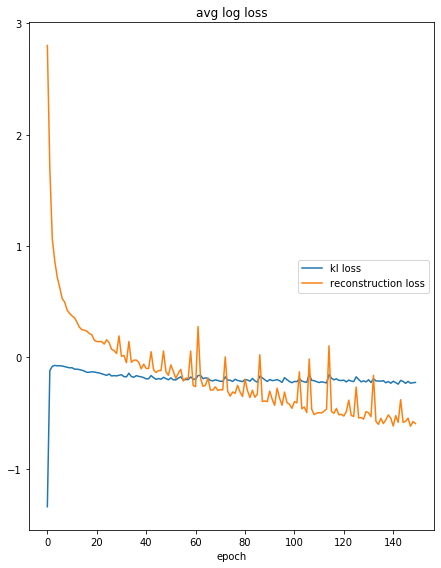

avg log loss
	kl loss          	 (min:   -1.341, max:   -0.071, cur:   -0.224)
	reconstruction loss 	 (min:   -0.617, max:    2.802, cur:   -0.594)


In [9]:
trained_standard_VAE  = train(sprites_dataset, epochs, standard_VAE)

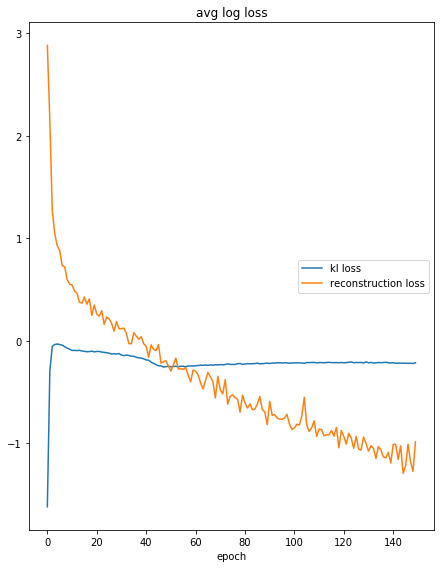

avg log loss
	kl loss          	 (min:   -1.619, max:   -0.031, cur:   -0.214)
	reconstruction loss 	 (min:   -1.294, max:    2.883, cur:   -0.984)


In [10]:
trained_SBD_VAE = train(sprites_dataset, epochs, SBD_VAE)

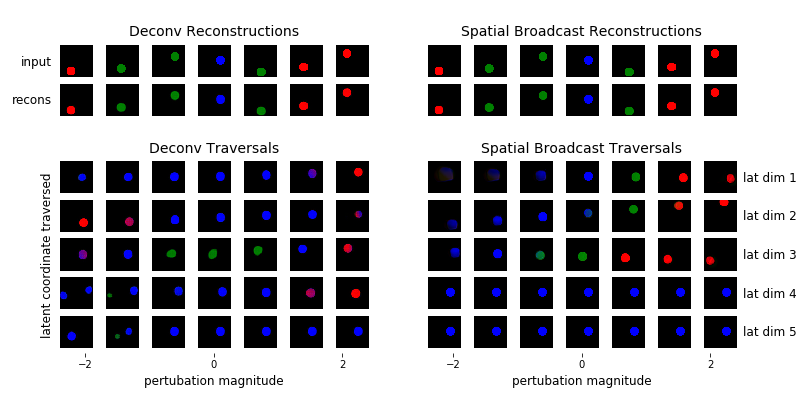

In [11]:
reconstructions_and_latent_traversals(trained_standard_VAE, 
                                      trained_SBD_VAE, sprites_dataset)

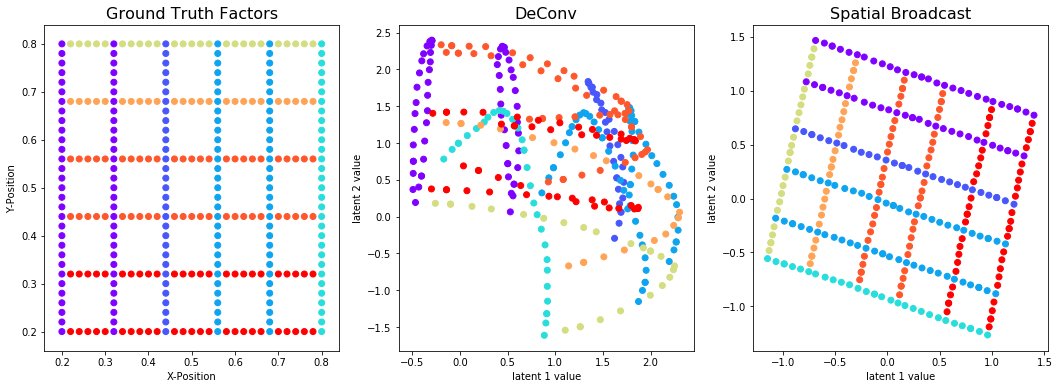

In [12]:
latent_space_geometry(trained_standard_VAE, trained_SBD_VAE)